# American Option, LSMC, Convertible Bond

옵션은 만기에만 행사가 가능한 유러피안 옵션과 언제라도 행사가 가능한 아메리칸 옵션 두 종류로 나뉩니다. 이번 강의에서는 아메리칸 옵션을 평가하는 방법론을 공부하고, 이를 통해 전환사채를 평가합니다.

## 1. 아메리칸 옵션의 평가방법

아메리칸 옵션의 보유자는 보유하고 있는 기간 동안 끊임없이 보유하고 있는 옵션의 가격과 옵션을 지금 행사했을 때 얻게 되는 현금흐름을 비교합니다. 그리고 만약 옵션을 행사했을 때 얻게 되는 현금흐름, 즉 행사가치가 보유하고 있는 옵션의 가격인 보유가치보다 높아지게 되면 해당 옵션을 조기행사합니다.<br>
 아메리칸 옵션의 평가는 기존의 평가방법에 이러한 판단을 도입하는 것으로 실행할 수 있습니다. 다만 현실적으로 모든 시간에 대해 해당 과정을 반복하는 것은 불가능하기에, 몬테카를로 시뮬레이션과 유한차분법의 단위시간마다 해당 가치 비교를 시행합니다.
 
### 1-1. 유한차분법을 이용한 아메리칸 옵션의 평가

유한차분법은 각 시점마다 옵션의 가격을 계산하는 방법론이기 때문에 간단하게 가치 비교를 시행할 수 있습니다. 해당 격자점에서의 옵션의 가격과 행사가치를 비교해서 더 큰 값이 해당 격자점에서의 아메리칸 옵션의 가치가 됩니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy
from scipy.stats import norm
N = norm.cdf

def DeltaBS(S, K, T, r, q, sigma):
    if T == 0:
        if S>K:
            return 1
        else:
            return 0
    else:
        d1 = (np.log(S / (K) + (r - q + ( 0.5) * sigma ** 2) * T)) / (sigma * np.sqrt(T))
        d2 = d1 -  sigma * np.sqrt(T)
        return  N(d1)    
def a(S,t,dS,dt,r,sigma) :
    a1 = 0.5*((sigma*S)/dS)**2
    a2 = 0.5*r*S/dS
    return -a1-a2
def b(S,t,dS,dt,r,sigma) :
    b1 = ((sigma*S)/dS)**2
    return r + b1
def c(S,t,dS,dt,r,sigma) :
    c1 = 0.5*((sigma*S)/dS)**2
    c2 = 0.5*r*S/dS
    return -c1+c2
def ai(S,t,dS,dt,r,sigma) :
    return a(S,t,dS,dt,r,sigma) * dt
def bi(S,t,dS,dt,r,sigma) :
    return b(S,t,dS,dt,r,sigma) * dt +1
def ci(S,t,dS,dt,r,sigma) :
    return c(S,t,dS,dt,r,sigma) * dt
def matrix(Smax,t,dS,dt,r,sigma):
    N = int(Smax/dS)
    mat = np.zeros([N,N])
    mat[0,0] = 2*ci(dS,t,dS,dt,r,sigma)+bi(dS,t,dS,dt,r,sigma)
    mat[0,1] = -ci(dS,t,dS,dt,r,sigma)+ai(dS,t,dS,dt,r,sigma)
    for i in range(1,N-1):
        mat[i,i-1] = ci((i+1)*dS,t,dS,dt,r,sigma)
        mat[i,i] = bi((i+1)*dS,t,dS,dt,r,sigma)
        mat[i,i+1] = ai((i+1)*dS,t,dS,dt,r,sigma)
    mat[N-1,N-2] = ci(Smax,t,dS,dt,r,sigma)-ai(Smax,t,dS,dt,r,sigma)
    mat[N-1,N-1] = bi(Smax,t,dS,dt,r,sigma)+2*ai(Smax,t,dS,dt,r,sigma)
    return mat

s0 = 100
K = 100
q = 0
r = 0.02
sigma = 0.2
T = 1
days = 250
nsimulation = 10000
dt = 1/250
dS = 1

In [2]:
mean = np.exp(r+0.5*sigma**2)
var = (np.exp(sigma**2)-1)*(np.exp(2*r+sigma**2))
Smax = np.ceil(mean+5*np.sqrt(var))*100
call = pd.DataFrame(index = np.arange(dS,Smax+dS,dS), columns = range(1,252))
for i in call.index:
    call.loc[i,251] = np.maximum(i-K,0)

이제 원래의 유한차분법 과정에 각 노드에서의 가치를 비교하는 로직을 넣어주면 됩니다.

In [3]:
for i in range(1,251):
    t = (251-i)/250
    v = np.array(call[251-i+1])
    call[251-i] = np.linalg.inv(matrix(Smax,t,dS,dt,r,sigma))@v
    for j in range(0,int(Smax)):# 로직 추가
        if call.loc[j+1,251-i]<np.maximum(j+1-K,0):
            call.loc[j+1,251-i] = np.maximum(j+1-K,0)

In [4]:
call.loc[100,1]

8.909483361601229

해당 로직을 넣지 않은 평가, 즉 유러피안 옵션의 가격도 구해서 비교를 합니다.

In [5]:
call2 = pd.DataFrame(index = np.arange(dS,Smax+dS,dS), columns = range(1,252))
for i in call.index:
    call2.loc[i,251] = np.maximum(i-K,0)
for i in range(1,251):
    t = (251-i)/250
    v = np.array(call2[251-i+1])
    call2[251-i] = np.linalg.inv(matrix(Smax,t,dS,dt,r,sigma))@v
print(call2.loc[100,1])

8.909483361601229


이처럼 배당이 없는 주식의 아메리칸 콜옵션은 조기행사가 되지 않기에 유러피안 콜옵션과 같은 가격을 가집니다.<br>
이제 아메리칸 풋옵션의 가치와 유러피안 풋옵션의 가치를 비교하겠습니다.

In [6]:
put = pd.DataFrame(index = np.arange(dS,Smax+dS,dS), columns = range(1,252))
put2 = pd.DataFrame(index = np.arange(dS,Smax+dS,dS), columns = range(1,252))
for i in put.index:
    put.loc[i,251] = np.maximum(K-i,0)
    put2.loc[i,251] = np.maximum(K-i,0)
for i in range(1,251):
    t = (251-i)/250
    v = np.array(put[251-i+1])
    put[251-i] = np.linalg.inv(matrix(Smax,t,dS,dt,r,sigma))@v
    for j in range(0,int(Smax)):# 로직 추가
        if put.loc[j+1,251-i]<np.maximum(K-j-1,0):
            put.loc[j+1,251-i] = np.maximum(K-j-1,0)    
print(put.loc[100,1])

for i in range(1,251):
    t = (251-i)/250
    v = np.array(put2[251-i+1])
    put2[251-i] = np.linalg.inv(matrix(Smax,t,dS,dt,r,sigma))@v
print(put2.loc[100,1])

7.100543046961538
6.929429104019949


아메리칸 풋옵션은 유러피안 풋옵션의 가치보다 높은 것을 확인할 수 있습니다. 이를 그래프로 그리면 다음과 같습니다.

<Axes: >

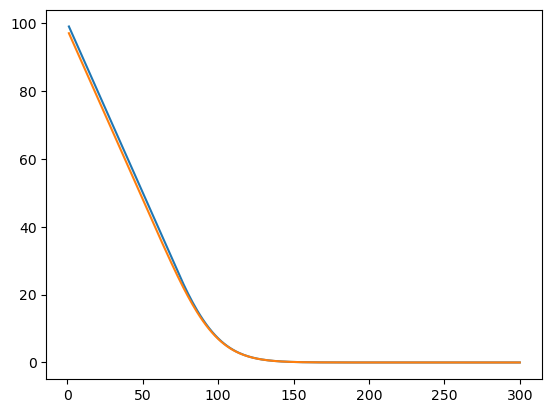

In [7]:
put.loc[:,1].plot()
put2.loc[:,1].plot()

옵션의 가격의 차이가 내가격으로 가면 갈수록 커지는 것을 확인할 수 있습니다. 즉 아메리칸 풋옵션은 심내가격에서 조기행사됩니다.

### 1-2. 몬테카를로 시뮬레이션을 이용한 아메리칸 옵션의 평가

몬테카를로 시뮬레이션으로는 아메리칸 옵션을 평가하기가 쉽지 않습니다. 몬테카를로 시뮬레이션은 각 시점마다의 주가만 관측할 수 있을 뿐 그 시점에서의 옵션의 가격은 Closed-Form Solution이 없는 이상 알 수 없기 때문입니다. 그래서 나온 방법이 LSMC(Least Square Monte Carlo simulation)입니다.<br>
LSMC는 다음과 같은 과정으로 평가를 진행합니다.
1. 각 path의 종점에서의 옵션의 행사가치를 계산합니다.
2. 다음 과정을 시작시점+1일 까지 반복합니다.<br>
2-1. T시점에서의 주식가격이 내가격인 path들을 골라낸 후 해당 path들에 한해서, T+1에서의 각 path의 옵션가격의 T시점에서의 가치를 종속변수로, T에서의 각 path의 주식가격, 주식가격의 제곱을 독립변수로 두고 회귀분석을 시행합니다.<br>
2-2. T시점에서의 각 path에서의 주식가격을 회귀식에 대입한 값을 해당 시점, 해당 path에서의 옵션가격으로 설정합니다.<br>
2-3. 각 path별로 옵션가격과 행사가치를 비교하여 큰 값을 해당 시점, 해당 path에서의 옵션의 가치로 설정합니다.<br>
2-4. T시점에서의 주식가격이 외가격인 path의 경우 T+1 시점에서의 옵션가격을 할인한 가격을 해당 시점의 옵션가격으로 설정합니다.
3. 시작시점+1일의 모든 path에서의 옵션가격의 평균값을 할인해 시작시점에서의 가치를 구합니다.<br>

따라서 이를 시행하기 위해서는 path 데이터프레임과 옵션가치 데이터프레임, 총 두 개의 데이터프레임이 필요합니다.

In [8]:
Normal = np.random.normal(size=(T*days, nsimulation))
path = np.zeros((T*days+1,nsimulation))
path[0] = s0
logds = r*dt + Normal * sigma*np.sqrt(dt)
for i in range(1,T*days+1):
    path[i] = path[i-1]*(1+logds[i-1])

In [9]:
Path = pd.DataFrame(0,index = range(1,nsimulation+1),columns = range(1,T*days+2))

In [10]:
Path+=path.T

In [11]:
LSMC = pd.DataFrame(index = range(1,nsimulation+1),columns = range(1,T*days+2))

아메리칸 옵션과 유러피안 옵션의 차이가 있던 풋옵션의 평가를 진행합니다.

In [12]:
for i in LSMC.index:
    LSMC.loc[i,251] = np.maximum(K-Path.loc[i,251],0)

이제 각 시점마다 회귀분석으로 옵션가치를 추정하는 과정을 구현합니다.

In [13]:
for i in range(0,249):
    ITM = np.where(Path[250-i]<K)[0]
    y = np.array(LSMC[251-i])*np.exp(-r*dt)
    y = y[ITM]
    X = np.zeros([10000,3])
    X[:,0]+=1
    X[:,1]+=Path[250-i]
    X[:,2]+=Path[250-i]**2
    X = X[ITM]
    b = np.linalg.inv(X.T@X)@X.T@y
    EY = X@b
    Value = np.maximum(EY,np.maximum(K-Path[250-i][ITM+1],0))
    LSMC[250-i] = LSMC[251-i]*np.exp(-r*dt)
    for j in ITM:
        LSMC.loc[j+1,250-i] = Value[j+1]

1일차의 주식 가격이 모두 같기 때문에 회귀분석 진행이 불가능합니다. 이제 2일차의 옵션가격의 평균을 할인하여 아메리칸 풋옵션의 가격을 구합니다.

In [14]:
print(np.mean(LSMC[2])*np.exp(-r*dt))

7.280901649326944


LSMC의 결과값 역시 유러피안 풋옵션보다 높은 것을 확인할 수 있습니다.